In [ ]:
from google.colab import drive
drive.mount("drive", force_remount=True)

Mounted at drive


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image

import glob, os, random

In [ ]:
# PATH_DATASET = 'drive/Shareddrives/B21-CAP0331/dataset/dataset-2'
DATASET_URL = "https://storage.googleapis.com/cosmic-quarter-312712/dataset/dataset-v2.zip"
PATH_DATASET = tf.keras.utils.get_file('dataset.zip', origin=DATASET_URL, extract=True)

In [ ]:
# BASE_PATH = PATH_DATASET
BASE_PATH = '/root/.keras/datasets/'
os.listdir(BASE_PATH)

['paper', 'plastic', 'metal', 'cardboard', 'glass', 'dataset-v2.zip']

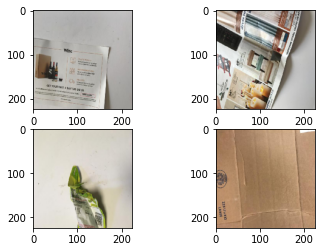

In [ ]:
img_list = glob.glob(os.path.join(BASE_PATH, '*/*.jpg'))

for i, img_path in enumerate(random.sample(img_list, 4)):
    img = image.load_img(img_path, target_size=(224, 224))
    img = image.img_to_array(img, dtype=np.uint8)
    plt.subplot(2, 2, i+1)
    plt.imshow(img.squeeze())

In [ ]:
train_datagen = ImageDataGenerator(
    rescale = 1./255.,
    rotation_range = 40,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    shear_range = 0.1,
    zoom_range = 0.1,
    horizontal_flip = True,
    vertical_flip = True,
    validation_split = 0.1
)

test_datagen = ImageDataGenerator(
    rescale = 1./255.,
    validation_split = 0.1
)

train_generator = train_datagen.flow_from_directory(
    BASE_PATH,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    subset='training',
    seed=0
)

validation_generator = test_datagen.flow_from_directory(
    BASE_PATH,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    subset='validation',
    seed=0
)

Found 2152 images belonging to 5 classes.
Found 238 images belonging to 5 classes.


In [ ]:
list_labels = train_generator.class_indices
keys_list_labels = list_labels.keys()
print(list_labels)

labels = '\n'.join(sorted(keys_list_labels))
with open('labels.txt', 'w') as f:
  f.write(labels)

path = 'labels.txt'
label = np.array(open(path).read().splitlines())

{'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4}


In [ ]:
from datetime import datetime
import pickle

def save_model(model, history, modelComment):
  modelDate = datetime.now().strftime("%Y-%m-%d_%H-%M") + "_" + modelComment
  savePath = "drive/Shareddrives/B21-CAP0331/models/" + modelDate
  !mkdir "$savePath"
  tf.saved_model.save(model, savePath)
  with open(savePath + "/history.pickle", "wb") as f:
    pickle.dump(history.history, f)
  print("Model saved to ", savePath)
  print("Model name : ", modelDate)
  drive.flush_and_unmount()
  print("Drive flushed out")
  drive.mount("drive")


# MOBILENET V2

In [ ]:
IMG_SHAPE = (224,224,3)
BASE_MODEL = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SHAPE,
    include_top=False,
    weights='imagenet'
    )

9412608/9406464 [==============================] - 0s 0us/step


In [ ]:
BASE_MODEL.trainable = False

In [ ]:
model = tf.keras.Sequential([
  BASE_MODEL,
  tf.keras.layers.Conv2D(128, 3, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(len(keys_list_labels), activation='softmax')
])

In [ ]:
base_lr = 0.0001
model.compile(
    optimizer=tf.keras.optimizers.RMSprop(lr=base_lr),
    loss='categorical_crossentropy',
    metrics=['accuracy']
    )
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
conv2d (Conv2D)              (None, 5, 5, 128)         1474688   
_________________________________________________________________
dropout (Dropout)            (None, 5, 5, 128)         0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 5)                 645       
Total params: 3,733,317
Trainable params: 1,475,333
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
batch_size = 128
epochs = 50
steps_per_epoch = train_generator.n // batch_size
validation_steps = validation_generator.n // batch_size

history = model.fit(
    train_generator,
    steps_per_epoch = steps_per_epoch,
    epochs=epochs,
    workers = 4,
    validation_data = validation_generator,
    validation_steps = validation_steps,
    verbose = 1
    )

Epoch 1/50
16/16 [==============================] - 56s 1s/step - loss: 1.6298 - accuracy: 0.4248 - val_loss: 0.8777 - val_accuracy: 0.6875
Epoch 2/50
16/16 [==============================] - 30s 2s/step - loss: 0.8519 - accuracy: 0.6747 - val_loss: 1.2060 - val_accuracy: 0.5625
Epoch 3/50
16/16 [==============================] - 26s 1s/step - loss: 0.7675 - accuracy: 0.7316 - val_loss: 0.6228 - val_accuracy: 0.6250
Epoch 4/50
16/16 [==============================] - 19s 971ms/step - loss: 0.7095 - accuracy: 0.7282 - val_loss: 0.7781 - val_accuracy: 0.5625
Epoch 5/50
16/16 [==============================] - 19s 980ms/step - loss: 0.6348 - accuracy: 0.7500 - val_loss: 0.4947 - val_accuracy: 0.7500
Epoch 6/50
16/16 [==============================] - 15s 815ms/step - loss: 0.6807 - accuracy: 0.7338 - val_loss: 0.5076 - val_accuracy: 0.7500
Epoch 7/50
16/16 [==============================] - 12s 554ms/step - loss: 0.6686 - accuracy: 0.7611 - val_loss: 0.7013 - val_accuracy: 0.6250
Epoch 8/

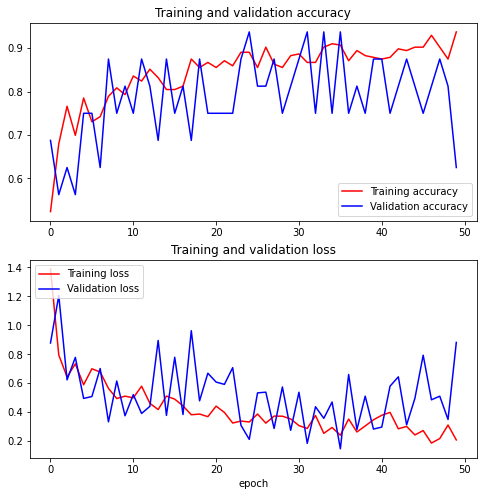

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(epochs_range, acc, 'r', label='Training accuracy')
plt.plot(epochs_range, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)

plt.subplot(2, 1, 2)
plt.plot(epochs_range, loss, 'r', label='Training loss')
plt.plot(epochs_range, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc='upper left')

plt.xlabel('epoch')

plt.show()

In [ ]:
save_model(model, history, "mobilenetv2_50epochs")

INFO:tensorflow:Assets written to: drive/Shareddrives/B21-CAP0331/models/2021-05-21_08-44_mobilenetv2_50epochs/assets
Model saved to  drive/Shareddrives/B21-CAP0331/models/2021-05-21_08-44_mobilenetv2_50epochs
Model name :  2021-05-21_08-44_mobilenetv2_50epochs
Drive flushed out
Mounted at drive


# Xception

In [ ]:
IMG_SHAPE = (224,224,3)
BASE_MODEL = tf.keras.applications.Xception(
    input_shape=IMG_SHAPE,
    include_top=False,
    weights='imagenet'
    )

83689472/83683744 [==============================] - 1s 0us/step


In [ ]:
BASE_MODEL.trainable = False

In [ ]:
model = tf.keras.Sequential([
  BASE_MODEL,
  tf.keras.layers.Conv2D(128, 3, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(len(keys_list_labels), activation='softmax')
])

In [ ]:
base_lr = 0.0001
model.compile(
    optimizer=tf.keras.optimizers.RMSprop(lr=base_lr),
    loss='categorical_crossentropy',
    metrics=['accuracy']
    )
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 7, 7, 2048)        20861480  
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 5, 5, 128)         2359424   
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 5, 128)         0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 645       
Total params: 23,221,549
Trainable params: 2,360,069
Non-trainable params: 20,861,480
_________________________________________________________________


In [ ]:
batch_size = 128
epochs = 50
steps_per_epoch = train_generator.n // batch_size
validation_steps = validation_generator.n // batch_size

history = model.fit(
    train_generator,
    steps_per_epoch = steps_per_epoch,
    epochs=epochs,
    workers = 4,
    validation_data = validation_generator,
    validation_steps = validation_steps,
    verbose = 1
    )

Epoch 1/50
16/16 [==============================] - 9s 234ms/step - loss: 1.6308 - accuracy: 0.3834 - val_loss: 1.0722 - val_accuracy: 0.6250
Epoch 2/50
16/16 [==============================] - 4s 193ms/step - loss: 0.7147 - accuracy: 0.7386 - val_loss: 0.1462 - val_accuracy: 1.0000
Epoch 3/50
16/16 [==============================] - 4s 192ms/step - loss: 0.6800 - accuracy: 0.7322 - val_loss: 0.3275 - val_accuracy: 0.9375
Epoch 4/50
16/16 [==============================] - 4s 183ms/step - loss: 0.5086 - accuracy: 0.7770 - val_loss: 0.4236 - val_accuracy: 0.8125
Epoch 5/50
16/16 [==============================] - 4s 187ms/step - loss: 0.5528 - accuracy: 0.8095 - val_loss: 1.0272 - val_accuracy: 0.6875
Epoch 6/50
16/16 [==============================] - 4s 193ms/step - loss: 0.5213 - accuracy: 0.7812 - val_loss: 0.6468 - val_accuracy: 0.8125
Epoch 7/50
16/16 [==============================] - 4s 222ms/step - loss: 0.4411 - accuracy: 0.8318 - val_loss: 0.4198 - val_accuracy: 0.8125
Epoch 

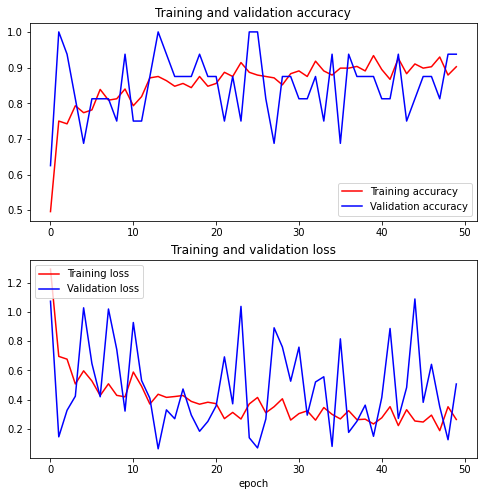

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(epochs_range, acc, 'r', label='Training accuracy')
plt.plot(epochs_range, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)

plt.subplot(2, 1, 2)
plt.plot(epochs_range, loss, 'r', label='Training loss')
plt.plot(epochs_range, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc='upper left')

plt.xlabel('epoch')

plt.show()

In [ ]:
save_model(model, history, "xception_50epochs")

INFO:tensorflow:Assets written to: drive/Shareddrives/B21-CAP0331/models/2021-05-21_08-48_xception_50epochs/assets
Model saved to  drive/Shareddrives/B21-CAP0331/models/2021-05-21_08-48_xception_50epochs
Model name :  2021-05-21_08-48_xception_50epochs
Drive flushed out
Mounted at drive


# VGG16

In [ ]:
IMG_SHAPE = (224,224,3)
BASE_MODEL = tf.keras.applications.VGG16(
    input_shape=IMG_SHAPE,
    include_top=False,
    weights='imagenet'
    )

58892288/58889256 [==============================] - 1s 0us/step


In [ ]:
BASE_MODEL.trainable = False

In [ ]:
model = tf.keras.Sequential([
  BASE_MODEL,
  tf.keras.layers.Conv2D(128, 3, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(len(keys_list_labels), activation='softmax')
])

In [ ]:
base_lr = 0.0001
model.compile(
    optimizer=tf.keras.optimizers.RMSprop(lr=base_lr),
    loss='categorical_crossentropy',
    metrics=['accuracy']
    )
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 5, 5, 128)         589952    
_________________________________________________________________
dropout_2 (Dropout)          (None, 5, 5, 128)         0         
_________________________________________________________________
global_average_pooling2d_2 ( (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 645       
Total params: 15,305,285
Trainable params: 590,597
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
batch_size = 128
epochs = 50
steps_per_epoch = train_generator.n // batch_size
validation_steps = validation_generator.n // batch_size

history = model.fit(
    train_generator,
    steps_per_epoch = steps_per_epoch,
    epochs=epochs,
    workers = 4,
    validation_data = validation_generator,
    validation_steps = validation_steps,
    verbose = 1
    )

Epoch 1/50
16/16 [==============================] - 7s 173ms/step - loss: 1.6207 - accuracy: 0.2947 - val_loss: 1.3386 - val_accuracy: 0.4375
Epoch 2/50
16/16 [==============================] - 4s 181ms/step - loss: 1.3420 - accuracy: 0.5128 - val_loss: 1.3354 - val_accuracy: 0.4375
Epoch 3/50
16/16 [==============================] - 4s 178ms/step - loss: 1.2896 - accuracy: 0.4778 - val_loss: 1.2633 - val_accuracy: 0.3125
Epoch 4/50
16/16 [==============================] - 4s 181ms/step - loss: 1.2571 - accuracy: 0.4972 - val_loss: 1.2009 - val_accuracy: 0.5625
Epoch 5/50
16/16 [==============================] - 4s 175ms/step - loss: 1.1889 - accuracy: 0.4883 - val_loss: 1.0328 - val_accuracy: 0.5625
Epoch 6/50
16/16 [==============================] - 4s 186ms/step - loss: 1.1178 - accuracy: 0.5476 - val_loss: 1.0135 - val_accuracy: 0.5625
Epoch 7/50
16/16 [==============================] - 5s 252ms/step - loss: 1.0483 - accuracy: 0.5560 - val_loss: 1.0345 - val_accuracy: 0.5625
Epoch 

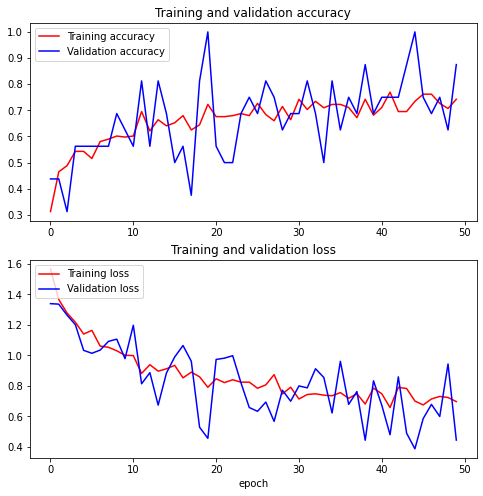

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(epochs_range, acc, 'r', label='Training accuracy')
plt.plot(epochs_range, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)

plt.subplot(2, 1, 2)
plt.plot(epochs_range, loss, 'r', label='Training loss')
plt.plot(epochs_range, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc='upper left')

plt.xlabel('epoch')

plt.show()

In [ ]:
save_model(model, history, "vgg16_50epochs")

INFO:tensorflow:Assets written to: drive/Shareddrives/B21-CAP0331/models/2021-05-21_08-52_vgg16_50epochs/assets
Model saved to  drive/Shareddrives/B21-CAP0331/models/2021-05-21_08-52_vgg16_50epochs
Model name :  2021-05-21_08-52_vgg16_50epochs
Drive flushed out
Mounted at drive


# Testing

In [ ]:
def load_model(modelName):
  loadPath = "drive/Shareddrives/B21-CAP0331/models/" + modelName
  return tf.keras.models.load_model(loadPath)

model = load_model("2021-05-21_08-44_mobilenetv2_50epochs")

In [ ]:
from google.colab import files

uploaded = files.upload()

#img_path = BASE_PATH + '/plastic/plastic9.jpg'
for img_path in uploaded.keys():
  img = image.load_img(img_path, target_size=(224, 224))
  img = image.img_to_array(img, dtype=np.uint8)
  plt.imshow(img.squeeze())
  img = img / 255.
  p=model.predict(img[np.newaxis, ...])
  print(p)
  predicted_class = label[np.argmax(p[0], axis=-1)]
  print(predicted_class)

In [ ]:
PATH_DATASET = 'drive/Shareddrives/B21-CAP0331/dataset/dataset-2/'
list_labels = ['cardboard', 'glass', 'metal', 'paper', 'plastic']

# img_path = PATH_DATASET + 'cardboard/cardboard100.jpg'

i = 0
for cls in list_labels:
  path = PATH_DATASET + cls + '/'
  miss = 0
  count = 0
  for files in os.listdir(path):
    img_path = path + files
    img = image.load_img(img_path, target_size=(224, 224))
    img = image.img_to_array(img, dtype=np.uint8)
    # plt.imshow(img.squeeze())
    img = img / 255
    p = model.predict(img[np.newaxis, ...])
    # print(p)
    idx = np.argmax(p[0], axis=-1)
    if (idx != i):
      miss += 1
    count += 1
    # predicted_class = list_labels[idx]
    # print(predicted_class)
  i += 1
  print ('-----')
  print (cls)
  print('count', count)
  print('miss', miss)
  print ('-----')

-----
cardboard
count 403
miss 11
-----
-----
glass
count 501
miss 133
-----
-----
metal
count 410
miss 7
-----
-----
paper
count 594
miss 78
-----
-----
plastic
count 482
miss 23
-----


[[1.62791242e-04 1.22255735e-01 7.99749553e-01 2.55300407e-03
  7.52789676e-02]]
2
metal


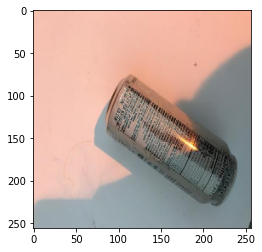

In [ ]:
path = PATH_DATASET + 'metal/'
files = 'metal101.jpg'

img_path = path + files
img = image.load_img(img_path, target_size=(256, 256))
img = image.img_to_array(img, dtype=np.uint8)
plt.imshow(img.squeeze())
img = img / 255
p = model.predict(img[np.newaxis, ...])
print(p)
idx = np.argmax(p[0], axis=-1)
print(idx)
predicted_class = list_labels[idx]
print(predicted_class)